## GMM Estimation of Model Parameters

- This notebook includes functions that estimate the parameter of rigidity for different models
- It allows for flexible choices of moments to be used, forecast error, disagreement, and uncertainty, etc. 
- It includes 
  - A general function that implements the estimation using the minimum distance algorithm. 
  - Model-specific functions that take real-time data and process parameters as inputs and produces forecasts and moments as outputs. It is model-specific because different models of expectation formation bring about different forecasts. 
  - Auxiliary functions that compute the moments as well as the difference of data and model prediction, which will be used as inputs for GMM estimator. 

### 1. Estimation algorithms 

In [46]:
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import arma_generate_sample

In [47]:
# a estimating function of the parameter
def Estimator(obj_func,para_guess,method='CG'):
    """
    Inputs
    ------
    - moments: a function of the rigidity model parameter  
    - method: method of optimization 
    
    Outputs
    -------
    - parameter: an array of estimated parameter
    """
    
    parameter = minimize(obj_func,x0 = para_guess,method=method)['x']
    return parameter 

In [48]:
# a function that prepares moment conditions
def PrepMom(model_moments,data_moments):
    """
    Inputs
    -----
    model_moments: an array of moments from a certain model, i.e. forecast error, disagreement and uncertainty. 
    data_moments: an array of moments computed from the survey data
    
    Outputs
    ------
    diff: the Euclidean distance of two arrays of data and model 
    
    """
    diff = np.linalg.norm(model_moments - data_moments)
    return diff

In [49]:
## some parameters 
rho = 0.95
sigma = 0.1
process_para = {'rho':rho,
                'sigma':sigma}

In [50]:
## auxiliary functions 
def hstepvar(h,sigma,rho):
    return sum([ rho**(2*i)*sigma**2 for i in range(h)] )

np.random.seed(12345)
def hstepfe(h,sigma,rho):
    return sum([rho**i*(np.random.randn(1)*sigma)*np.random.randn(h)[i] for i in range(h)])
## This is not correct. 


def AR1_simulator(rho,sigma,nobs):
    xxx = np.zeros(nobs+1)
    shocks = np.random.randn(nobs+1)*sigma
    xxx[0] = 0 
    for i in range(nobs):
        xxx[i+1] = rho*xxx[i] + shocks[i+1]
    return xxx[1:]


def ForecastPlot(test):
    plt.figure(figsize=([3,13]))
    for i,val in enumerate(test):
        plt.subplot(4,1,i+1)
        plt.plot(test[val],label=val)
        plt.legend(loc=1)
        
        
def ForecastPlotDiag(test,data):
    plt.figure(figsize=([3,13]))
    for i,val in enumerate(test):
        plt.subplot(4,1,i+1)
        plt.plot(test[val],label='model:'+val)
        plt.plot(np.array(data[val]),label='data:'+val)
        plt.legend(loc=1)

In [51]:
## AR1 series for testing 
nobs = 100
rho = process_para['rho']
sigma = process_para['sigma']
xxx = AR1_simulator(rho,sigma,nobs)

In [52]:
# a function that generates population moments according to FIRE 
def FIREForecaster(real_time,horizon =10,process_para = process_para):
    n = len(real_time)
    rho = process_para['rho']
    sigma = process_para['sigma']
    Disg =np.zeros(n)
    FE = np.random.rand(n)*sigma  ## forecast errors depend on realized shocks 
    infoset = real_time
    nowcast = infoset
    forecast = rho**horizon*nowcast
    Var = hstepvar(horizon,sigma,rho)* np.ones(n)
    return {"Forecast":forecast,
            "FE":FE,
           "Disg":Disg,
           "Var":Var}

In [53]:
## simulate a AR1 series for testing 
FIREtest = FIREForecaster(xxx,horizon=1)

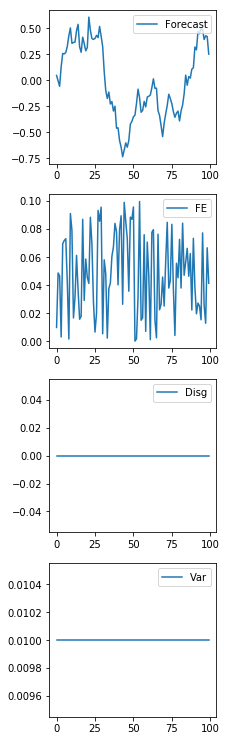

In [54]:
# plot different moments for FIRE
ForecastPlot(FIREtest)

In [55]:
## SE parameters

SE_FE_para = {'lambda':1}
SE_para = {'lambda':0.75}
SE_para2 = {'lambda':0.25}

In [56]:
# a function that generates population moments according to SE 
def SEForecaster(real_time,horizon =10,process_para = process_para,exp_para = SE_para):
    n = len(real_time)
    rho = process_para['rho']
    sigma = process_para['sigma']
    lbd = exp_para['lambda']
    max_back = 10 # need to avoid magic numbers 
    FE = sum( [lbd*(1-lbd)**tau*hstepfe(horizon+tau,sigma,rho) for tau in range(max_back)] ) * np.ones(n) # a function of lambda, real-time and process_para 
    Var = sum([ lbd*(1-lbd)**tau*hstepvar(horizon+tau,sigma,rho) for tau in range(max_back)] ) * np.ones(n)  
    # same as above 
    nowcast = sum([ lbd*(1-lbd)**tau*(rho**tau)*np.roll(real_time,tau) for tau in range(max_back)]) 
    # the first tau needs to be burned
    forecast = rho**horizon*nowcast
    Disg =  sum([ lbd*(1-lbd)**tau*(rho**(tau+horizon)*np.roll(real_time,tau)-forecast)**2 for tau in range(max_back)] )
    return {"Forecast":forecast, 
            "FE":FE,
            "Disg":Disg,
            "Var":Var}

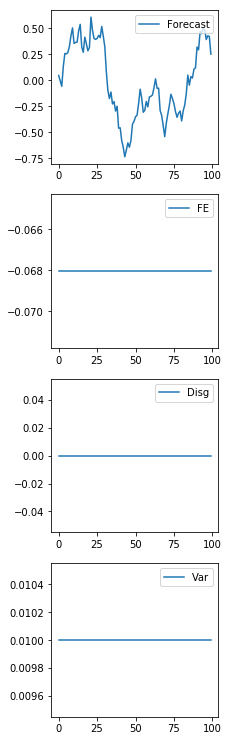

In [57]:
## check if SE collapses to FIRE when lambda=1

FE_from_SE = SEForecaster(xxx,horizon=1,exp_para = SE_FE_para)
ForecastPlot(FE_from_SE)

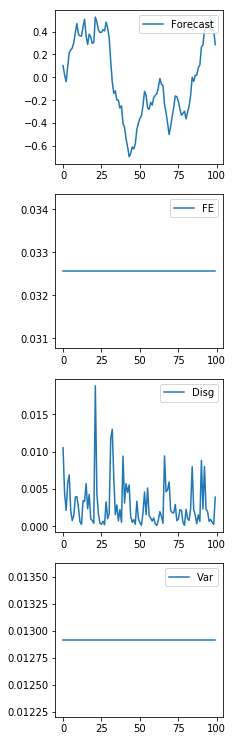

In [58]:
## test 

SEtest = SEForecaster(xxx,horizon=1)
ForecastPlot(SEtest)

In [59]:
## prepare inputs for the estimation

horizon = 1
real_time = xxx 
process_para = process_para

## some fake data using a different lambda
SEtest2 = SEForecaster(xxx,horizon=1,exp_para = SE_para2)
data_moms_dct = SEtest2

In [60]:
## a function estimating SE model parameter only 

def SE_EstObjfunc(lbd,moments = ['Forecast','Disg','Var']):
    """
    input
    -----
    lbd: the parameter of SE model to be estimated
    
    output
    -----
    the objective function to minmize
    """

    SE_para = {"lambda":lbd}
    SE_moms_dct = SEForecaster(real_time,horizon=1,process_para = process_para,exp_para = SE_para)
    SE_moms = np.array([SE_moms_dct[key] for key in moments] )
    data_moms = np.array([data_moms_dct[key] for key in moments] )
    obj_func = PrepMom(SE_moms,data_moms)
    return obj_func 

In [61]:
## invoke the estimation of SE 

lbd_est = Estimator(SE_EstObjfunc,para_guess =0.5,method='CG')
lbd_est

array([0.5])

In [62]:
# a function that generates population moments according to NI 
def NIForecaster(real_time,horizon =10,process_para = process_para,exp_para = exp_para):
    rho = process_para['rho']
    sigma = process_para['sigma']
    sigma_pr = exp_para['sigma_pr']
    sigma_pb = exp_para['sigma_pb']
    
    NIFE = # a function of lambda, real-time and process_para 
    NIDisg = 0 # same as above
    NIVar = # same as above 
    return {"FE":NIFE,
           "Disg":NIDisg,
           "Var":NIVar}

SyntaxError: invalid syntax (<ipython-input-62-d78c263bed00>, line 8)

### 2. Estimating using real-time inflation and expectation data

In [63]:
import pandas as pd

## exapectation data 
PopQ=pd.read_stata('../SurveyData/InfExpQ.dta')  
PopQ = PopQ[-PopQ.date.isnull()]

dateQ = pd.to_datetime(PopQ['date'],format='%Y%m%d')

dateQ_str = dateQ.dt.year.astype(int).astype(str) + \
             "Q" + dateQ.dt.quarter.astype(int).astype(str)
PopQ.index = pd.DatetimeIndex(dateQ_str)

SPFCPI = PopQ[['SPFCPI_Mean','SPFCPI_FE','SPFCPI_Disg','SPFCPI_Var']].dropna(how='any')

## exapectation data 
InfQ = pd.read_stata('../OtherData/InfShocksQClean.dta')
InfQ = InfQ[-InfQ.date.isnull()]
dateQ2 = pd.to_datetime(InfQ['date'],format='%Y%m%d')
dateQ_str2 = dateQ2 .dt.year.astype(int).astype(str) + \
             "Q" + dateQ2 .dt.quarter.astype(int).astype(str)
InfQ.index = pd.DatetimeIndex(dateQ_str2)

In [64]:
Comb = pd.concat([SPFCPI,InfQ['Inf1y_CPICore']], join='inner', axis=1)

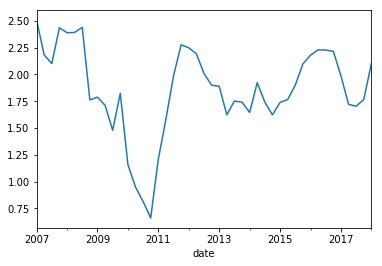

In [65]:
# real time inflation 
real_time = np.array(Comb['Inf1y_CPICore'])
Comb['Inf1y_CPICore'].plot()

In [32]:
## preparing for estimation 

exp_data = Comb[['SPFCPI_Mean','SPFCPI_FE','SPFCPI_Disg','SPFCPI_Var']]
exp_data.columns = ['Forecast','FE','Disg','Var']
data_moms_dct = dict(exp_data)

In [33]:
## estimation 
lbd_est = Estimator(SE_EstObjfunc,para_guess =0.2,method='CG')

In [34]:
lbd_est

## rough estimation that did not take care of following issues
## quarterly survey of 1-year-ahead forecast
## real-time data is yearly 

array([0.66776221])

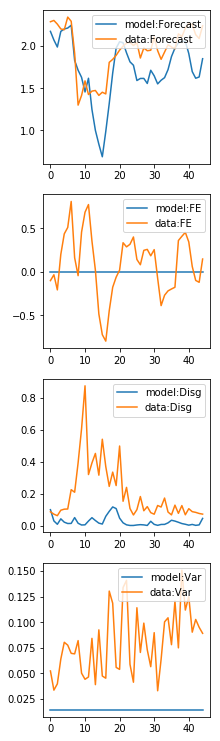

In [35]:
## compare the data with estimation

SE_para_est = {"lambda":lbd_est}

SE_est = SEForecaster(real_time,horizon=1,exp_para = SE_para_est)

ForecastPlotDiag(SE_est,data_moms_dct)